In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import expon

#### Informazione sulla cartella:

I risultati dell'esercizio $7.1$ e dell'esercizio $7.4$ si trovano nelle cartelle 'Solido', 'Liquido' e 'Gas' contenute nelle cartelle con lo stesso nome dell'esercizio.

Dell'esercizio $7.2$ e $7.3$ non sono mostrati i risultati poichè sono mostrati nell'esercizio $7.4$.

Inoltre il codice dell'esercizio $7.4$ è inserito in cartelle diverse: quella terminante con '_NVE' continene i codici per la simulazione nell'insieme microcanonico, l'altra quelli per l'inisieme canonico. Inoltre i codice del sistema micorcanonico producono sia i risultati senza le correzioni di coda sia con le correzioni di coda poichè lo stesso codice viene utilizzato nell'esercizio $4.4$. 

Per generare nuovamente i file dei risultati basta usare il comando 'make' da terminale per compilare ed eseguire i codici. I file verrano generati automaticamente nella cartella corretta così che è sufficiente eseguire nuovamente il notebook per visualizzarli. L'esecuzione dei file in C++ richiede diversi minuti.

## Descrizione del sistema

Nei seguenti esercizi è stata svolta una simulazione di un sistema di $N_{particelle}=108$ particelle in una scatola cubica di lato $l$ con condizioni periodiche al contorno campionando il peso di Boltzmann $p(\{ \vec{x}_i \}) = \frac{e^{-\beta V}}{Z}$, in cui $V$ è la somma su tutte le possibili coppie del sistema del potenziale di Lennard-Jones e $Z$ è la funzione di partizione, nei seguenti stati termodinamici:
* fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c^\star = 2.2$)
* fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c^\star = 2.5$)
* fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c^\star = 5.0$).

Il simbolo $\star$ inidica che le grandezze sono espresse in unità di Lennard-Jones.

Tutte le simulazioni iniziano con una fase di equlibrazione un certo numero di passi del Metropolis $N_{eq}$: ogni passo corrisponde a scegliere per $N_{particelle}$ volte una particelle casualmente e modificarne la pozione sommando un passo casuale di ampiezza $a$. Tale ampiezza è stata scelta in modo che nella fase di equlibrazione la probabilità che una nuova configurazione venga accettata sia $\sim 50 \%$. Nella tabella sottostante sono riportati i paramtri utilizzati:

 |Solido | Liquido | Gas
-------|--------|--------|--------
$a$|0.12|0.2|6.0
$N_{eq}$|2000 |2000|5000

Il passo fissato per la fase gassosa porta ad una probabilità di accettazione di  di $\sim 62\%$, è possibile ridurre la probabilità di accetazione ulterormente aumentando $a$ a causa delle condizioni periodiche al contorno poichè l'ampiezza vale già $a=\frac{l}{2}$.

Dopo l'equilibrazione l'algoritmo è stato eseguito per un numero $N = 100$ di blocchi comoposti da $L=10^3$ passi.

## Esercizio 07.1

### Autocorrelazione di pressione ed energia potenziale

#### Funzioni per analisi dati:

In [3]:
def Auto_corr(x,t):
    t_max=len(x)
    norm=(1./(t_max-t))
    x_old=x[0:t_max-t]
    x_new=x[t:]
    
    num= norm*np.sum(x_old*x_new)-(norm**2)*np.sum(x_old)*np.sum(x_new)
    den=(1./t_max)*np.sum(x**2)- ((1./t_max)*np.sum(x))**2
    return num/den


def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L): 

    M=len(r)
    N = int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        
    return err_prog[len(err_prog)-1]

In [6]:
pres_ist_sol = np.loadtxt("7.1/Solido/istant.pres.0", usecols=(0), unpack='true')
epot_ist_sol = np.loadtxt("7.1/Solido/istant.epot.0", usecols=(0), unpack='true')

pres_ist_liq = np.loadtxt("7.1/Liquido/istant.pres.0", usecols=(0), unpack='true')
epot_ist_liq = np.loadtxt("7.1/Liquido/istant.epot.0", usecols=(0), unpack='true')

pres_ist_gas = np.loadtxt("7.1/Gas/istant.pres.0", usecols=(0), unpack='true')
epot_ist_gas = np.loadtxt("7.1/Gas/istant.epot.0", usecols=(0), unpack='true')

Dopo aver implementato nel codice un metodo che salvasse su file i valori istantanei di pressione ed enegia potenziale è stata calcolata l'autocorrelazione di queste grandezze, inidicate genericamente con $x(t)$, nella fase solida, liquida e gassosa $$AC(\tau)= \frac{\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')x(t'+\tau)-\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')\times \frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t'+\tau)}{\frac{1}{t}\sum_{t' = 0}^{t}x^2(t')-\left(\frac{1}{t}\sum_{t' = 0}^{t}x(t')\right)^2} \, ,
$$

tramite il metodo 'Auto_corr' implementato nelle celle sovrastanti. In questo caso il tempo è inteso come il tempo Monte Carlo della simulazione.

Le autocorrelazioni ricavate sono state fittate con una legge esponenziale $ AC(\tau)= exp ( - \frac{\tau}{\tau_c})$ per ricavare una stima del tempo di autocorrelazione delle grandezze del sistema ed utilizzare blocchi di dati non correlati  fra loro (il numero dei dati deve essere almeno $2 \tau_c$) per il calcolo delle grandezze medie negli esercizi successivi.

Nella seguente tabella sono riassunti i risultati mostrati nei grafici sottostanti:

|Solido | Liquido | Gas
-------|--------|--------|--------
$\tau_c$ dell'energia potenziale|8.12|9.44|2.57
$\tau_c$ della pressione|7.98 |12.40|0.97

C:\Users\aless\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


tempo di correlazione energia potenziale:  8.122486209174362
tempo di correlazione pressione:  7.986876812178945


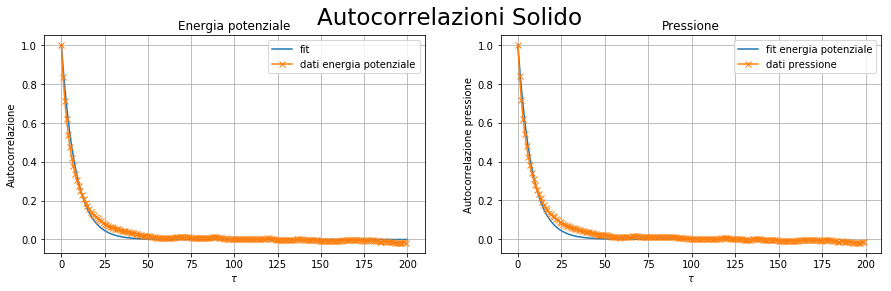

tempo di correlazione energia potenziale:  9.441707069975068
tempo di correlazione pressione:  12.407117751528565


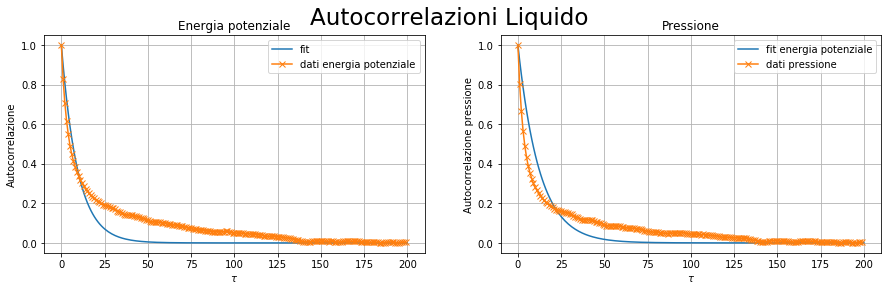

tempo di correlazione energia potenziale:  2.571257658478895
tempo di correlazione pressione:  0.8730583717034336


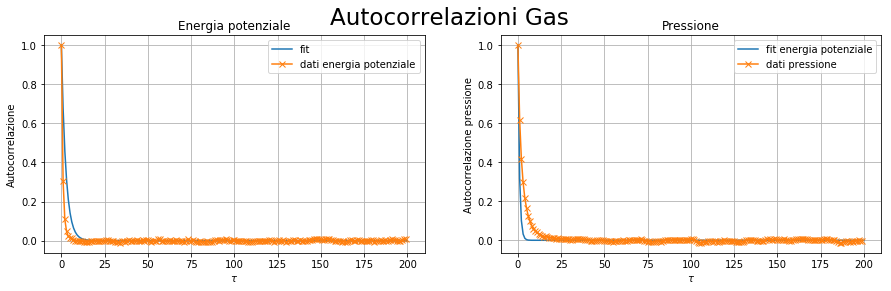

In [7]:
n_dati=len(pres_ist_sol)
n_punti=int(n_dati/500)

correlation_pres_sol=np.zeros(n_punti)
for t in range(n_punti):
    correlation_pres_sol[t]=Auto_corr(pres_ist_sol,t)

correlation_epot_sol=np.zeros(n_punti)
for t in range(n_punti):
    correlation_epot_sol[t]=Auto_corr(epot_ist_sol,t)

t=np.linspace(0,n_punti, n_punti)

plt.figure(figsize=(15,4))
plt.suptitle('Autocorrelazioni Solido',fontsize=23)

plt.subplot(1,2,1)
f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_epot_sol)
x = np.linspace(0, 200, 200)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit')
print('tempo di correlazione energia potenziale: ', 1/f[0][1])

plt.plot(correlation_pres_sol, label='dati energia potenziale', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione')
#plt.yscale('Log')
plt.legend()
plt.grid(True)
plt.title('Energia potenziale')

plt.subplot(1,2,2)

f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_pres_sol)
x = np.linspace(0, 100, 100)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit energia potenziale')
#plt.yscale('Log')
print('tempo di correlazione pressione: ', 1/f[0][1])

plt.plot(correlation_epot_sol, label='dati pressione', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione pressione')
#plt.yscale('Log')
plt.grid(True)
plt.legend()
plt.title('Pressione')


plt.show()

#liquido


correlation_pres_liq=np.zeros(n_punti)
for t in range(n_punti):
    correlation_pres_liq[t]=Auto_corr(pres_ist_liq,t)

correlation_epot_liq=np.zeros(n_punti)
for t in range(n_punti):
    correlation_epot_liq[t]=Auto_corr(epot_ist_liq,t)

t=np.linspace(0,n_punti, n_punti)

plt.figure(figsize=(15,4))
plt.suptitle('Autocorrelazioni Liquido',fontsize=23)

plt.subplot(1,2,1)
f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_epot_liq)
x = np.linspace(0, 200, 200)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit')
print('tempo di correlazione energia potenziale: ', 1/f[0][1])

plt.plot(correlation_pres_liq, label='dati energia potenziale', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione')
#plt.yscale('Log')
plt.legend()
plt.grid(True)
plt.title('Energia potenziale')

plt.subplot(1,2,2)

f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_pres_liq)
x = np.linspace(0, 200, 200)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit energia potenziale')
#plt.yscale('Log')
print('tempo di correlazione pressione: ', 1/f[0][1])

plt.plot(correlation_epot_liq, label='dati pressione', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione pressione')
#plt.yscale('Log')
plt.grid(True)
plt.legend()
plt.title('Pressione')



plt.show()

#gas



correlation_pres_gas=np.zeros(n_punti)
for t in range(n_punti):
    correlation_pres_gas[t]=Auto_corr(pres_ist_gas,t)

correlation_epot_gas=np.zeros(n_punti)
for t in range(n_punti):
    correlation_epot_gas[t]=Auto_corr(epot_ist_gas,t)

t=np.linspace(0,n_punti, n_punti)

plt.figure(figsize=(15,4))
plt.suptitle('Autocorrelazioni Gas',fontsize=23)

plt.subplot(1,2,1)
f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_epot_gas)
x = np.linspace(0, 200, 200)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit')
print('tempo di correlazione energia potenziale: ', 1/f[0][1])

plt.plot(correlation_pres_gas, label='dati energia potenziale', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione')
#plt.yscale('Log')
plt.legend()
plt.grid(True)
plt.title('Energia potenziale')

plt.subplot(1,2,2)

f= scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l),t,correlation_pres_gas)
x = np.linspace(0, 200, 200)
y = f[0][0]*np.exp(-x*f[0][1])
plt.plot(x,y, label='fit energia potenziale')
#plt.yscale('Log')
print('tempo di correlazione pressione: ', 1/f[0][1])

plt.plot(correlation_epot_gas, label='dati pressione', marker='x')
plt.xlabel(r'$\tau$')
plt.ylabel('Autocorrelazione pressione')
#plt.yscale('Log')
plt.grid(True)
plt.legend()
plt.title('Pressione')


plt.show()

### Analisi degli errori in funzione della lunghezza dei blocchi

Dopo aver stimato il tempo di correlazione, si vuole stimare la lungheza $L$ che deve avere ogni blocco perchè i dati non siano correlati tra loro e quindi valga il teorema del limite centrale quando si effettua il data blocking. Per avere una stima di tale tempo Monte Carlo, è stato implementato il metodo 'blocking' che effettua il data blocking sul vettore di dati, che viene fornito in input, con blocchi di lunghezza $L$, il secondo parametro passato in input, e restistuisce la deviazione standard della media ottenuta usando tutti i blocchi.

Nei grafici sottostanti sono riportati i risultai per i valori istantanei di  $P$ e $U/N$ al variare della dimensione dei blocchi $L$ per tutte le tre fasi: solida, liquida e gassosa.

Si può osservare che, per tutte e tre le fasi, per $L > 500$ l'errore ha raggiunto la saturazione per cui i blocchi non sono correlati ed le ipotesi del teorema centrale del limite sono soddisfatte. Inoltre si osserva che $L \approx 500 \gt 2\tau_c$ cioè che i blocchi sono non correlati per tempi maggiori di almendo due volte il tempo di autocorrelazione. Infine si nota che nel gas, essendo i tempi di autocorrelazione molto ridotti, l'errore satura molto rapidamente.  

In [8]:
##solido
L=np.arange(10,5000,100)
err_pres_sol = np.zeros(len(L))
err_epot_sol = np.zeros(len(L))

s=0
for i in L:
    err_pres_sol[s]=blocking(pres_ist_sol,i)
    err_epot_sol[s]=blocking(epot_ist_sol,i)
    s+=1



In [9]:
# liquido
L=np.arange(10,5000,100)
err_pres_liq = np.zeros(len(L))
err_epot_liq = np.zeros(len(L))

s=0
for i in L:
    err_pres_liq[s]=blocking(pres_ist_liq,i)
    err_epot_liq[s]=blocking(epot_ist_liq,i)
    s+=1

In [10]:
#gas
L=np.arange(10,5000,100)
err_pres_gas = np.zeros(len(L))
err_epot_gas = np.zeros(len(L))

s=0
for i in L:
    err_pres_gas[s]=blocking(pres_ist_gas,i)
    err_epot_gas[s]=blocking(epot_ist_gas,i)
    s+=1

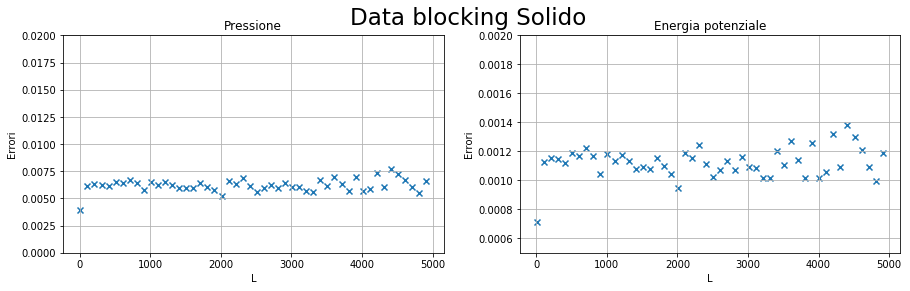

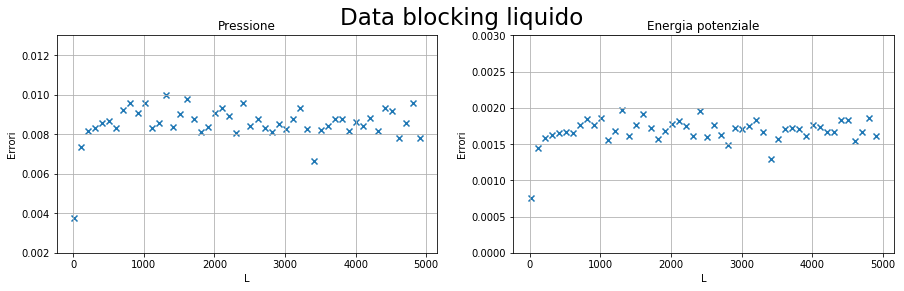

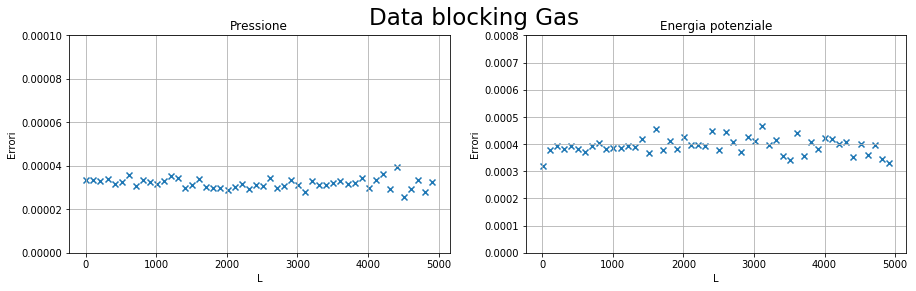

In [11]:
### grafici dei risultati

plt.figure(figsize=(15,4))
plt.suptitle('Data blocking Solido',fontsize=23)

plt.subplot(1,2,1)
plt.scatter(L,err_pres_sol, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0,0.02])
plt.title('Pressione')

plt.subplot(1,2,2)
plt.scatter(L,err_epot_sol, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0.0005,0.002])
plt.title('Energia potenziale')
plt.show()


#liquido

plt.figure(figsize=(15,4))
plt.suptitle('Data blocking liquido',fontsize=23)




plt.subplot(1,2,1)
plt.scatter(L,err_pres_liq, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0.002,0.013])
plt.title('Pressione')

plt.subplot(1,2,2)
plt.scatter(L,err_epot_liq, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0.00,0.003])
plt.title('Energia potenziale')
plt.show()


#gas

plt.figure(figsize=(15,4))
plt.suptitle('Data blocking Gas',fontsize=23)



plt.subplot(1,2,1)
plt.scatter(L,err_pres_gas, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0.00,0.0001])
plt.title('Pressione')

plt.subplot(1,2,2)
plt.scatter(L,err_epot_gas, marker='x')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)
plt.ylim([0.00,0.0008])
plt.title('Energia potenziale')
plt.show()

## Esercizio 7.4

Nell'esercizio 7.2 e 7.3 è stato implementato il calcolo della funzione di distribuzione radiale $g(r)$. L'utilizzo effettivo è avvenuto nell'eserczio 7.4 per cui vengono riportati solo i risultati di tale esercizio.

Per la simulazione di dinamica molecolare nell'insieme microcanonico è stato utilizzato proprio il codice descritto nella lezione 4 poichè già implementa il calcolo di $g(r)$ e le correzioni di coda alla pressione e all'energia potenziale.

Per la simulazione nell'insieme canonico si è fatto uso dei risultati precedenti utilizzando lo stesso numeri di passi e l'amipezza del passo per l'equilibrazione e $N=100$ blocchi da $L=1000$ dati ciascuno così che sicuramente le grandezze medie calcolate per ogni bloccho non sono correlate (essendo $L$ maggiore di quello a cui l'errore satura).

Nei grafici sottostanti sono riporti i valori medi, con i rispettivi errori, di $U/N$ e $P$ in funzione del numero di blocchi $N$ e la funzione di distribuzione radiale $g(r)$ al variare di $r$ ottenuti dalle simulazioni di fase solida, liquida e gassosa per Argon e Krypton (le grandezze hanno il medesimo andamento funzionale poiché sono riscalamenti diversi delle stesse grandezze adimensionate) sia nell'insieme microcanonico (N,V,E) sia nell'insieme canonio (N,V,T).

Si può notare che:

* La funzione di distribuzione radiale $g(r)$ ottenuta per le tre fasi sembra essere ragionevole e presentare in andamento anologo nei due inisemi: tutte e tre le fasi mostrano che ci è repulsione di hard-core tra le particelle $g(r < \sigma) =0$ e che le particelle tendono ad avere un ordinamento a breve range (picco di $g(r=\sigma)$). Nel solido poi vi è ordinamento anche a più lunga distanza come testimoniano i picchi ad $r=2\sigma$ ed $r=3 \sigma$. 
* Le $g(r)$ ottenute dall'iniseme microcanonico presentano qualche fluttuazione, che potrbbe essere abbattuta aumentnado il tempo di simulazione.
* I risultati ottenuti per NVE sono anologhi a quelli ottenuti dall'esercizio 4 con l'aggiunta delle correzioni di coda che traslano l'energia potenziale e la pressione senza modificarne l'andamento funzionale per cui valgono gli stessi commenti.

### Argon

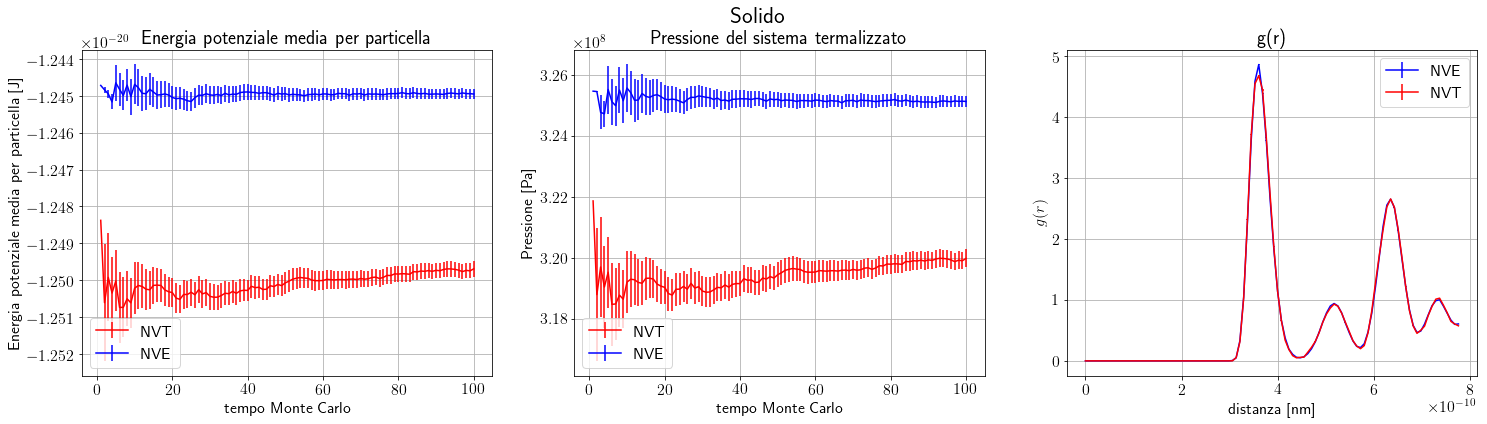

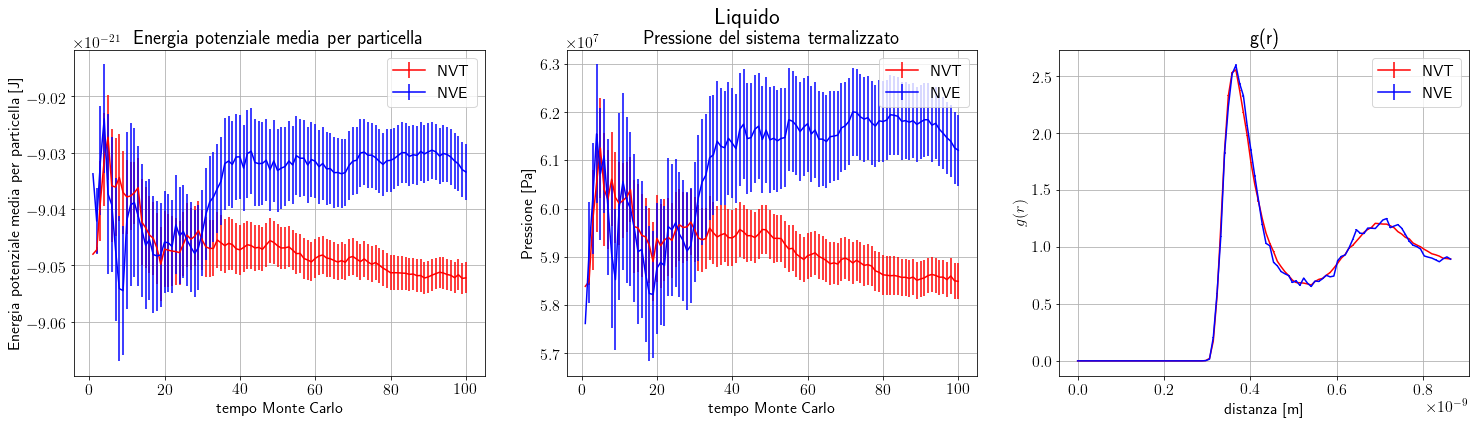

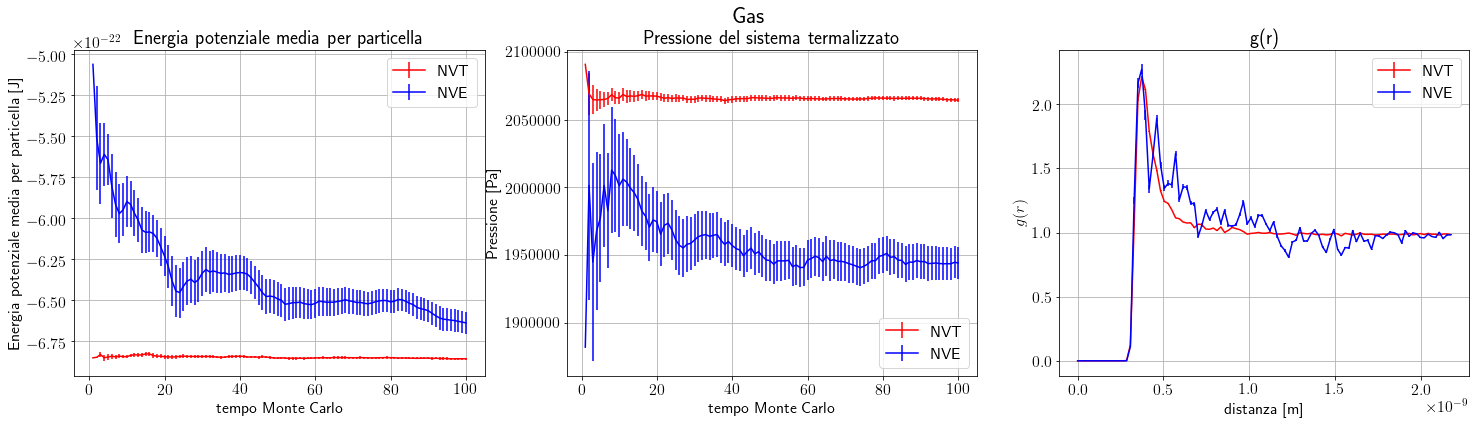

In [20]:
sigma=0.34 #nm
e_fratto_kb= 120. #K
m=39.948 #amu

epsilon= e_fratto_kb*1.38*10**(-23) #J
m= m*1.66*10**(-27) #kg
sigma=0.34*10**(-9) #m
t= 1000 # dati per blocco
p=epsilon/(sigma**3)

plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Solido',fontsize=23)



plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Solido/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)

x, y,error = np.loadtxt("7.4/Solido/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()



plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Solido/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Solido/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Solido/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Solido/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()






plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Liquido',fontsize=23)

plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Liquido/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)
plt.legend()

x, y,error = np.loadtxt("7.4/Liquido/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Liquido/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Liquido/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Liquido/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)

x, y, error = np.loadtxt("7.4/Liquido/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar((x-x[0]/2)*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()


plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Gas',fontsize=23)

plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Gas/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)
plt.legend()

x, y,error = np.loadtxt("7.4/Gas/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()



plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Gas/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Gas/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Gas/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)

x, y, error = np.loadtxt("7.4/Gas/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar((x-x[0]/2)*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()

### Krypton

I risultati ottenuti per il Krypton sono analoghi a quelli dell'Argon per cui valgono valgono gli stessi commenti.

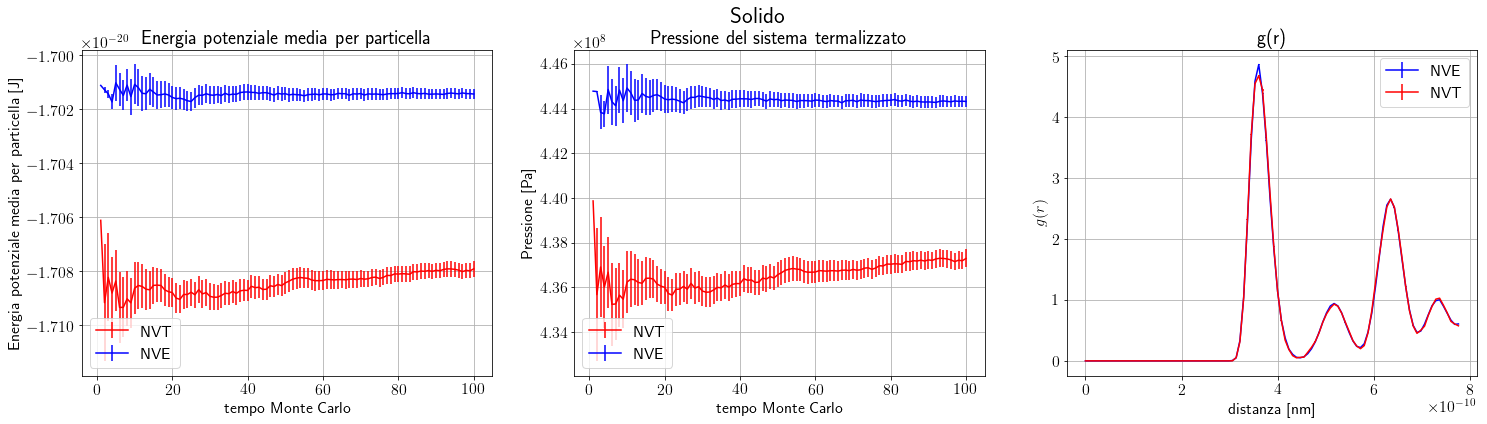

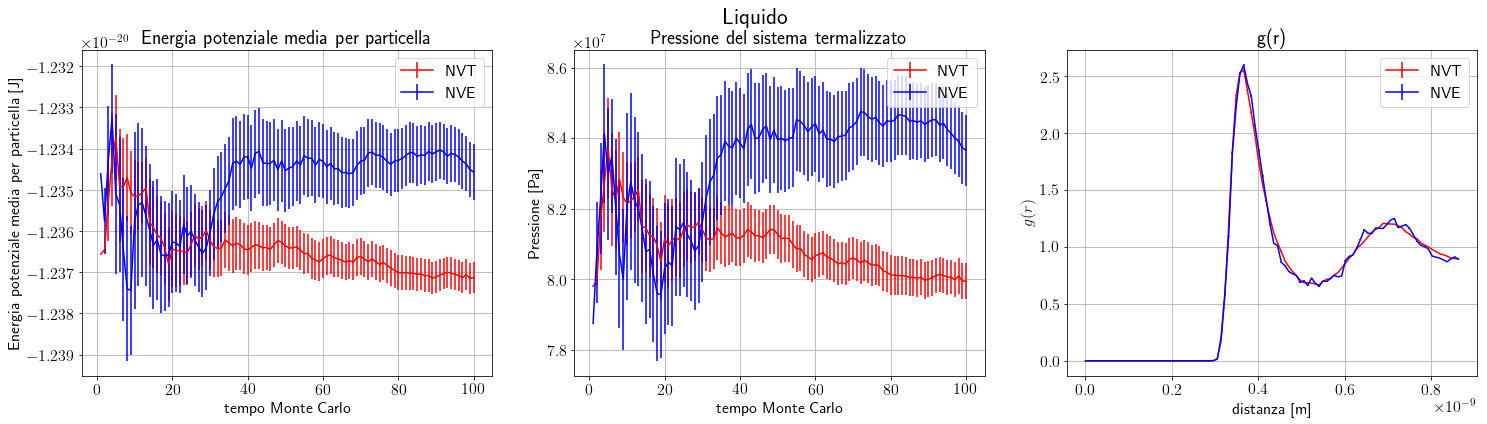

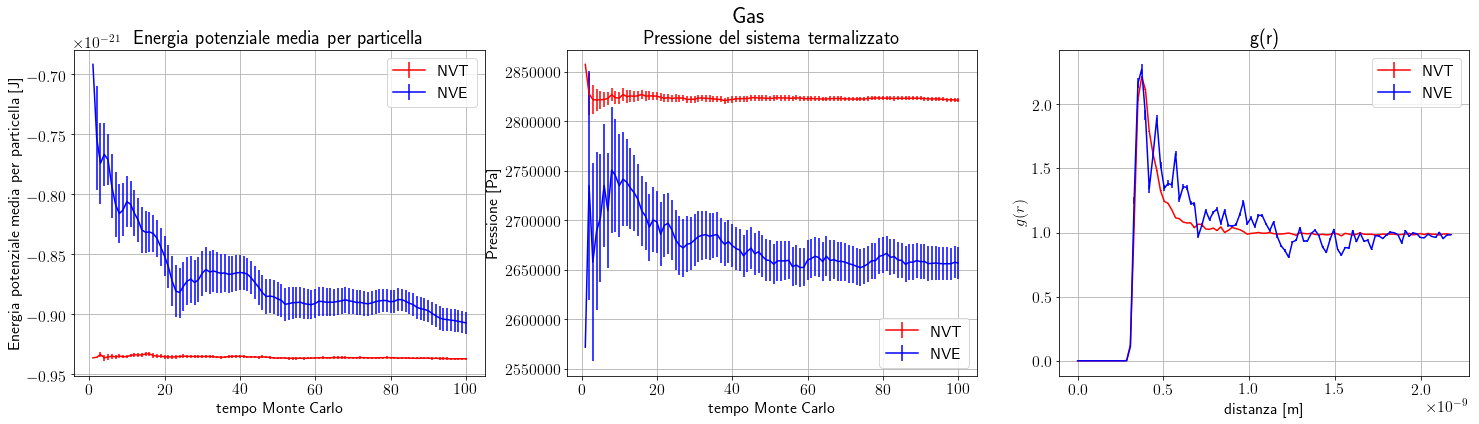

In [17]:
sigma=0.364 #nm
e_fratto_kb= 164. #K
m=83.798 #amu

epsilon= e_fratto_kb*1.38*10**(-23) #J
m= m*1.66*10**(-27) #kg
sigma=0.34*10**(-9) #m
t= 1000 # dati per blocco
p=epsilon/(sigma**3)

plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Solido',fontsize=23)



plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Solido/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)

x, y,error = np.loadtxt("7.4/Solido/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()



plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Solido/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Solido/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Solido/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Solido/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()






plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Liquido',fontsize=23)

plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Liquido/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)
plt.legend()

x, y,error = np.loadtxt("7.4/Liquido/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Liquido/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Liquido/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Liquido/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)

x, y, error = np.loadtxt("7.4/Liquido/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar((x-x[0]/2)*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()


plt.rc('text', usetex=True)
plt.rcParams['font.size']=16
plt.figure(figsize=(25,6))
plt.suptitle('Gas',fontsize=23)

plt.subplot(1,3,1)
x, y, error = np.loadtxt("7.4/Gas/output.epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color='red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Enegia potenziale [J]')
plt.title('Energia potenziale del sistema termalizzato')
plt.grid(True)
plt.legend()

x, y,error = np.loadtxt("7.4/Gas/ave_epot.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*epsilon,yerr=error*epsilon, color = 'blue', label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Energia potenziale media per particella [J]')
plt.title('Energia potenziale media per particella')
plt.grid(True)
plt.legend()



plt.subplot(1,3,2)
x, y, error = np.loadtxt("7.4/Gas/output.pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color = 'red', label='NVT')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione')
plt.grid(True)
plt.legend()

x, y, error = np.loadtxt("7.4/Gas/ave_pres.0", usecols=(0,2,3), unpack='true')
plt.errorbar(x,y*p,yerr=error*p, color='blue',label='NVE')
plt.xlabel('tempo Monte Carlo')
plt.ylabel('Pressione [Pa]')
plt.title('Pressione del sistema termalizzato')
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
x, y, error = np.loadtxt("7.4/Gas/output.gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar(x*sigma,y,yerr=error, color='red', label='NVT')
plt.xlabel('distanza [nm]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)

x, y, error = np.loadtxt("7.4/Gas/ave_gave.0", usecols=(0,1,2), unpack='true')
plt.errorbar((x-x[0]/2)*sigma,y,yerr=error, color='blue', label='NVE')
plt.xlabel('distanza [m]')
plt.ylabel(r'$g(r)$')
plt.title('g(r)')
plt.grid(True)
plt.legend()
plt.show()